In [32]:
import os
import shutil
import random
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

In [33]:
Train_dir = "Museum_Training/Training/"
Test_dir = "Museum_Test/Museum_Validation/"

classification_targets = ['museum-indoor', 'museum-outdoor']

def check_directory(directory):
    if os.path.exists(directory):
        print(f"Directory '{directory}' exists.")
    else:
        print(f"Directory '{directory}' does NOT exist.")

check_directory(Train_dir)
check_directory(Test_dir)

Directory 'Museum_Training/Training/' exists.
Directory 'Museum_Test/Museum_Validation/' exists.


In [15]:
# classification_targets = ['museum-indoor','museum-outdoor']

In [34]:
def show_dir_content(dir_content,classification_targets):
    
    print(f"Contents of the directory: {dir_content}")
    for clf in classification_targets:
        clf_dir = os.path.join(dir_content, clf)
        if os.path.exists(clf_dir):
            num_images = len(os.listdir(clf_dir))
            print(f"Class '{clf}' contains {num_images} images.")
        else:
            print(f"Class directory '{clf}' does not exist.")

show_dir_content(Train_dir,classification_targets)
show_dir_content(Test_dir,classification_targets)

Contents of the directory: Museum_Training/Training/
Class 'museum-indoor' contains 5000 images.
Class 'museum-outdoor' contains 5000 images.
Contents of the directory: Museum_Test/Museum_Validation/
Class 'museum-indoor' contains 100 images.
Class 'museum-outdoor' contains 100 images.


In [17]:

image_sizes = []
color_modes = []

for class_name in classification_targets:
    class_dir = os.path.join(Train_dir, class_name)
    if os.path.exists(class_dir):
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                img = Image.open(img_path)
                image_sizes.append(img.size) 
                color_modes.append(img.mode)  
            except:
                print(f"Error loading {img_path}")

df_sizes = pd.DataFrame(image_sizes, columns=["Width", "Height"])
df_modes = pd.DataFrame(color_modes, columns=["Color Mode"])

print("Image Size Distribution:")
print(df_sizes.describe())

print("\nColor Mode Counts:")
print(df_modes["Color Mode"].value_counts())

Image Size Distribution:
         Width   Height
count  10000.0  10000.0
mean     256.0    256.0
std        0.0      0.0
min      256.0    256.0
25%      256.0    256.0
50%      256.0    256.0
75%      256.0    256.0
max      256.0    256.0

Color Mode Counts:
RGB    10000
Name: Color Mode, dtype: int64


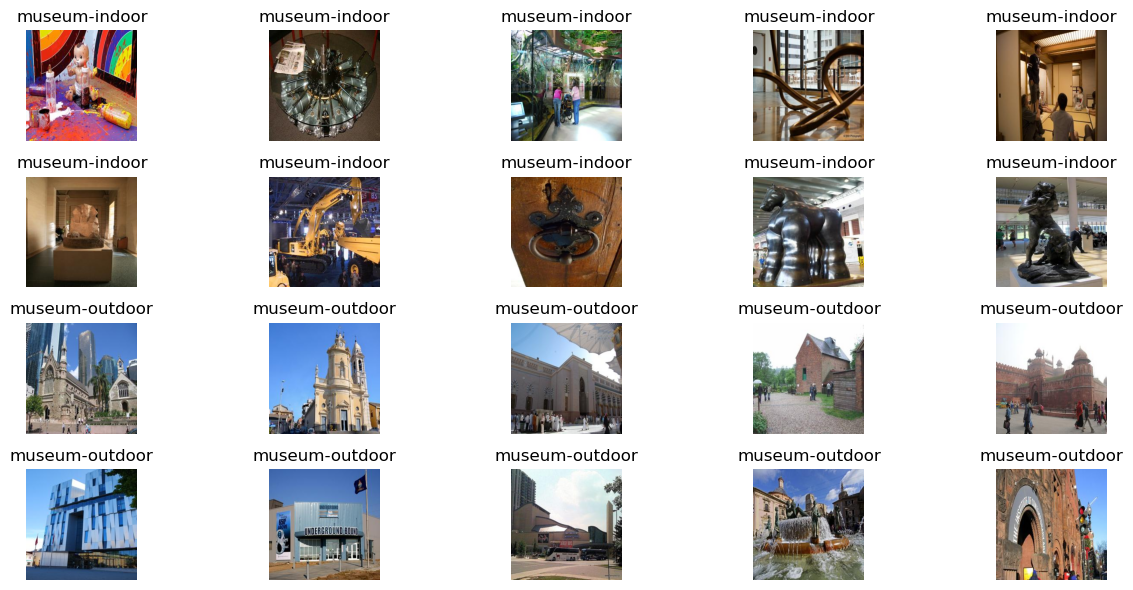

In [ ]:

def show_random_images_from_train(Train_dir, classification_targets, num_images=10, images_per_row=5):
    """
    Parameters:
    - Train_dir: Path to the training data directory.
    - classification_targets: List of class names.
    - num_images: Number of images to display per class.
    - images_per_row: Number of images to display in one row.
    """
    plt.figure(figsize=(13, 6))

    for class_idx, clf in enumerate(classification_targets):
        class_path = os.path.join(Train_dir, clf)

        if not os.path.exists(class_path):
            print(f" Class folder '{clf}' does NOT exist. Skipping.")
            continue

        image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

        if len(image_files) == 0:
            print(f" No images found in class '{clf}'. Skipping.")
            continue

        selected_images = random.sample(image_files, min(num_images, len(image_files)))

        rows = (num_images // images_per_row) + (num_images % images_per_row > 0)

        for i, img_name in enumerate(selected_images):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            if img is None:
                print(f" Could not read image: {img_path}. Skipping.")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

            ax = plt.subplot(len(classification_targets) * rows, images_per_row, class_idx * rows * images_per_row + i + 1)
            plt.imshow(img)
            plt.title(f"{clf}")
            plt.axis("off")

    plt.tight_layout()
    plt.show()

show_random_images_from_train(Train_dir, classification_targets, num_images=10)

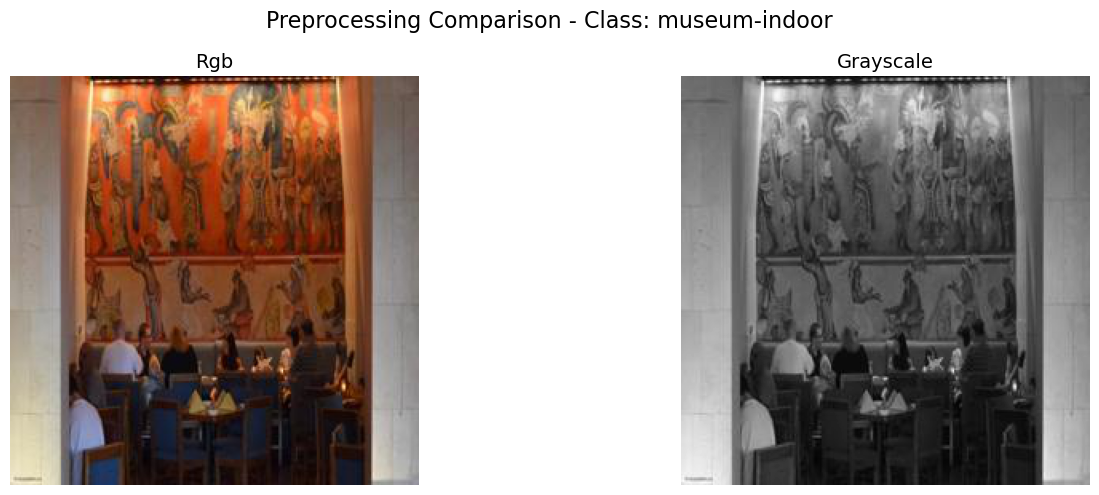

In [ ]:

def preprocess_image(img, method):
    img = img.convert('RGB') 
    img_array = np.array(img)
    img_gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)

    if method == 'rgb':
        return img_array 

    elif method == 'grayscale':
        return img_gray 

    else:
        raise ValueError("Invalid preprocessing method! Choose from: 'rgb', 'grayscale'.")

def get_random_image(target_dir, classes):
    """Select a random image from the dataset."""
    class_choice = random.choice(classes) 
    class_dir = os.path.join(target_dir, class_choice)
    img_name = random.choice(os.listdir(class_dir))  
    img_path = os.path.join(class_dir, img_name)
    return img_path, class_choice

def visualize_preprocessing(target_dir, classes, img_size=(256, 256), figsize=(12, 4)):
    """
    Parameters:
    - img_size: Resize image to this size before processing.
    - figsize: Figure size of the final plot.
    """
    img_path, selected_class = get_random_image(target_dir, classes)
    
    with Image.open(img_path) as img:
        img = img.resize(img_size)  
    
    methods = ['rgb', 'grayscale']
    fig, axes = plt.subplots(1, 2, figsize=figsize)  
    fig.suptitle(f"Preprocessing Comparison - Class: {selected_class}", fontsize=16)

    for i, method in enumerate(methods):
        processed_img = preprocess_image(img, method)
        ax = axes[i]  
        cmap = 'gray' if method != 'rgb' else None 
        ax.imshow(processed_img, cmap=cmap)
        ax.set_title(method.replace("_", " ").capitalize(), fontsize=14)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

visualize_preprocessing(Train_dir, classification_targets, img_size=(256, 256), figsize=(15, 5))


In [ ]:
def is_image_file(filename):
    
    valid_extensions = ('.jpg', '.jpeg', '.png')
    return filename.lower().endswith(valid_extensions)

def preprocess_images(target_dir, classes, image_size=(256,256)):
    """
    Parameters:
    - target_dir: Path to the target directory containing class folders.
    - classes : List of class names.
    - image_size: Desired image size (width, height).

    Returns:
    - X : Flattened image data.
    - y : Corresponding labels.

    """
    X = []
    y = []

    for label, cls in enumerate(classes):
        class_dir = os.path.join(target_dir, cls)
        for img_name in os.listdir(class_dir):
            if is_image_file(img_name):
                img_path = os.path.join(class_dir, img_name)
                try:
                    with Image.open(img_path) as img:
                        img = img.convert('RGB')  
                        img = img.resize(image_size)  
                        img_array = np.array(img).flatten()  
                        X.append(img_array)
                        y.append(label)
                except Exception as e:
                    print(f"Error processing file {img_path}: {e}")

    X = np.array(X)
    y = np.array(y)
    return X, y

X, y = preprocess_images(Train_dir, classification_targets)


print("Image data shape:", X.shape)
print("Labels shape:", y.shape)

Image data shape: (10000, 196608)
Labels shape: (10000,)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (8000, 196608)
Testing data shape: (2000, 196608)


In [23]:
# Define and train model
dt_model_entropy = DecisionTreeClassifier(criterion='entropy',max_depth=6,min_samples_split=2,random_state=42)
dt_model_entropy.fit(X_train, y_train)

y_train_pred = dt_model_entropy.predict(X_train)
y_test_pred = dt_model_entropy.predict(X_test)

accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

print('--- Training Metrics ---')
print("Accuracy:", accuracy_train)
print("Classification Report:\n", classification_report(y_train, y_train_pred, target_names=classification_targets))
print('Confusion Matrix:\n', cm_train)
print('\n--- Testing Metrics ---')
print("Accuracy:", accuracy_test)
print("Classification Report:\n", classification_report(y_test, y_test_pred, target_names=classification_targets))
print('Confusion Matrix:\n', cm_test)


--- Training Metrics ---
Accuracy: 0.898
Classification Report:
                 precision    recall  f1-score   support

 museum-indoor       0.87      0.94      0.90      4000
museum-outdoor       0.93      0.86      0.89      4000

      accuracy                           0.90      8000
     macro avg       0.90      0.90      0.90      8000
  weighted avg       0.90      0.90      0.90      8000

Confusion Matrix:
 [[3744  256]
 [ 560 3440]]

--- Testing Metrics ---
Accuracy: 0.8405
Classification Report:
                 precision    recall  f1-score   support

 museum-indoor       0.82      0.88      0.85      1000
museum-outdoor       0.87      0.81      0.83      1000

      accuracy                           0.84      2000
     macro avg       0.84      0.84      0.84      2000
  weighted avg       0.84      0.84      0.84      2000

Confusion Matrix:
 [[875 125]
 [194 806]]


In [24]:

dt_model_gini = DecisionTreeClassifier(criterion='gini',max_depth=5,min_samples_split=2,random_state=42)
dt_model_gini.fit(X_train, y_train)

y_train_pred = dt_model_gini.predict(X_train)
y_test_pred = dt_model_gini.predict(X_test)

accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

print('--- Training Metrics ---')
print("Accuracy:", accuracy_train)
print("Classification Report:\n", classification_report(y_train, y_train_pred, target_names=classification_targets))
print('Confusion Matrix:\n', cm_train)
print('\n--- Testing Metrics ---')
print("Accuracy:", accuracy_test)
print("Classification Report:\n", classification_report(y_test, y_test_pred, target_names=classification_targets))
print('Confusion Matrix:\n', cm_test)

--- Training Metrics ---
Accuracy: 0.885375
Classification Report:
                 precision    recall  f1-score   support

 museum-indoor       0.86      0.92      0.89      4000
museum-outdoor       0.91      0.85      0.88      4000

      accuracy                           0.89      8000
     macro avg       0.89      0.89      0.89      8000
  weighted avg       0.89      0.89      0.89      8000

Confusion Matrix:
 [[3666  334]
 [ 583 3417]]

--- Testing Metrics ---
Accuracy: 0.8575
Classification Report:
                 precision    recall  f1-score   support

 museum-indoor       0.83      0.90      0.86      1000
museum-outdoor       0.89      0.82      0.85      1000

      accuracy                           0.86      2000
     macro avg       0.86      0.86      0.86      2000
  weighted avg       0.86      0.86      0.86      2000

Confusion Matrix:
 [[898 102]
 [183 817]]


In [28]:

rf_model = RandomForestClassifier(max_depth=6,n_estimators=100, criterion='entropy', random_state=42) 
rf_model.fit(X_train, y_train)

y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

print('--- Training Metrics ---')
print("Accuracy:", accuracy_train)
print("Classification Report:\n", classification_report(y_train, y_train_pred, target_names=classification_targets))
print('Confusion Matrix:\n', cm_train)
print('\n--- Testing Metrics ---')
print("Accuracy:", accuracy_test)
print("Classification Report:\n", classification_report(y_test, y_test_pred, target_names=classification_targets))
print('Confusion Matrix:\n', cm_test)


--- Training Metrics ---
Accuracy: 0.91925
Classification Report:
                 precision    recall  f1-score   support

 museum-indoor       0.90      0.95      0.92      4000
museum-outdoor       0.95      0.89      0.92      4000

      accuracy                           0.92      8000
     macro avg       0.92      0.92      0.92      8000
  weighted avg       0.92      0.92      0.92      8000

Confusion Matrix:
 [[3795  205]
 [ 441 3559]]

--- Testing Metrics ---
Accuracy: 0.901
Classification Report:
                 precision    recall  f1-score   support

 museum-indoor       0.88      0.93      0.90      1000
museum-outdoor       0.93      0.87      0.90      1000

      accuracy                           0.90      2000
     macro avg       0.90      0.90      0.90      2000
  weighted avg       0.90      0.90      0.90      2000

Confusion Matrix:
 [[931  69]
 [129 871]]


In [29]:
rf_model_gini = RandomForestClassifier(max_depth=5,n_estimators=50, criterion='gini', random_state=42)  
rf_model_gini.fit(X_train, y_train)

y_train_pred = rf_model_gini.predict(X_train)
y_test_pred = rf_model_gini.predict(X_test)

accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

print('--- Training Metrics ---')
print("Accuracy:", accuracy_train)
print("Classification Report:\n", classification_report(y_train, y_train_pred, target_names=classification_targets))
print('Confusion Matrix:\n', cm_train)
print('\n--- Testing Metrics ---')
print("Accuracy:", accuracy_test)
print("Classification Report:\n", classification_report(y_test, y_test_pred, target_names=classification_targets))
print('Confusion Matrix:\n', cm_test)

--- Training Metrics ---
Accuracy: 0.8995
Classification Report:
                 precision    recall  f1-score   support

 museum-indoor       0.88      0.93      0.90      4000
museum-outdoor       0.92      0.87      0.90      4000

      accuracy                           0.90      8000
     macro avg       0.90      0.90      0.90      8000
  weighted avg       0.90      0.90      0.90      8000

Confusion Matrix:
 [[3702  298]
 [ 506 3494]]

--- Testing Metrics ---
Accuracy: 0.8885
Classification Report:
                 precision    recall  f1-score   support

 museum-indoor       0.87      0.91      0.89      1000
museum-outdoor       0.91      0.87      0.89      1000

      accuracy                           0.89      2000
     macro avg       0.89      0.89      0.89      2000
  weighted avg       0.89      0.89      0.89      2000

Confusion Matrix:
 [[910  90]
 [133 867]]


In [30]:
import pickle
with open("dt_model_gini.pkl", "wb") as dt_model_gini_file:
    pickle.dump(dt_model_gini, dt_model_gini_file)



In [31]:
with open("rf_model.pkl", "wb") as rf_model_file:
    pickle.dump(rf_model, rf_model_file)

In [ ]:
def preprocess_images128(target_dir, classes, image_size=(128,128)):
    X128 = []
    y128 = []

    for label, cls in enumerate(classes):
        class_dir = os.path.join(target_dir, cls)
        for img_name in os.listdir(class_dir):
            if is_image_file(img_name):
                img_path = os.path.join(class_dir, img_name)
                try:
                    with Image.open(img_path) as img:
                        img = img.convert('RGB')  
                        img = img.resize(image_size)  
                        img_array = np.array(img).flatten()  
                        X128.append(img_array)
                        y128.append(label)
                except Exception as e:
                    print(f"Error processing file {img_path}: {e}")

    X128 = np.array(X128)
    y128 = np.array(y128)
    return X128, y128

X128, y128 = preprocess_images128(Train_dir, classification_targets)


print("Image data shape:", X128.shape)
print("Labels shape:", y128.shape)

Image data shape: (10000, 49152)
Labels shape: (10000,)


In [37]:
X_train128, X_test128, y_train128, y_test128 = train_test_split(X128, y128, test_size=0.2, random_state=42, stratify=y)
print("Training data shape:", X_train128.shape)
print("Testing data shape:", X_test128.shape)

Training data shape: (8000, 49152)
Testing data shape: (2000, 49152)


In [38]:
xgb_model = XGBClassifier(max_depth=5, n_estimators=50, learning_rate=0.1, objective="multi:softmax", random_state=42,num_class=2)
xgb_model.fit(X_train128, y_train128)


y_train_pred_xgb = xgb_model.predict(X_train128)
y_test_pred_xgb = xgb_model.predict(X_test128)


accuracy_train_xgb = accuracy_score(y_train128, y_train_pred_xgb)
accuracy_test_xgb = accuracy_score(y_test128, y_test_pred_xgb)


cm_train_xgb = confusion_matrix(y_train128, y_train_pred_xgb)
cm_test_xgb = confusion_matrix(y_test128, y_test_pred_xgb)


print("\nXGBoost Training Metrics")
print("Accuracy:", accuracy_train_xgb)
print("Classification Report:\n", classification_report(y_train128, y_train_pred_xgb, target_names=classification_targets))
print("Confusion Matrix:\n", cm_train_xgb)

print("\nXGBoost Testing Metrics")
print("Accuracy:", accuracy_test_xgb)
print("Classification Report:\n", classification_report(y_test128, y_test_pred_xgb, target_names=classification_targets))
print("Confusion Matrix:\n", cm_test_xgb)


XGBoost Training Metrics
Accuracy: 0.96975
Classification Report:
                 precision    recall  f1-score   support

 museum-indoor       0.95      0.99      0.97      4000
museum-outdoor       0.99      0.95      0.97      4000

      accuracy                           0.97      8000
     macro avg       0.97      0.97      0.97      8000
  weighted avg       0.97      0.97      0.97      8000

Confusion Matrix:
 [[3958   42]
 [ 200 3800]]

XGBoost Testing Metrics
Accuracy: 0.905
Classification Report:
                 precision    recall  f1-score   support

 museum-indoor       0.89      0.93      0.91      1000
museum-outdoor       0.92      0.88      0.90      1000

      accuracy                           0.91      2000
     macro avg       0.91      0.91      0.90      2000
  weighted avg       0.91      0.91      0.90      2000

Confusion Matrix:
 [[927  73]
 [117 883]]


In [40]:
xgb_model1 = XGBClassifier(max_depth=4, n_estimators=80, learning_rate=0.1, objective="multi:softmax", random_state=42,num_class=2)
xgb_model1.fit(X_train128, y_train128)


y_train_pred_xgb = xgb_model1.predict(X_train128)
y_test_pred_xgb = xgb_model1.predict(X_test128)


accuracy_train_xgb = accuracy_score(y_train128, y_train_pred_xgb)
accuracy_test_xgb = accuracy_score(y_test128, y_test_pred_xgb)


cm_train_xgb = confusion_matrix(y_train128, y_train_pred_xgb)
cm_test_xgb = confusion_matrix(y_test128, y_test_pred_xgb)


print("\nXGBoost Training Metrics")
print("Accuracy:", accuracy_train_xgb)
print("Classification Report:\n", classification_report(y_train128, y_train_pred_xgb, target_names=classification_targets))
print("Confusion Matrix:\n", cm_train_xgb)

print("\nXGBoost Testing Metrics")
print("Accuracy:", accuracy_test_xgb)
print("Classification Report:\n", classification_report(y_test128, y_test_pred_xgb, target_names=classification_targets))
print("Confusion Matrix:\n", cm_test_xgb)


XGBoost Training Metrics
Accuracy: 0.9585
Classification Report:
                 precision    recall  f1-score   support

 museum-indoor       0.94      0.98      0.96      4000
museum-outdoor       0.98      0.94      0.96      4000

      accuracy                           0.96      8000
     macro avg       0.96      0.96      0.96      8000
  weighted avg       0.96      0.96      0.96      8000

Confusion Matrix:
 [[3922   78]
 [ 254 3746]]

XGBoost Testing Metrics
Accuracy: 0.9035
Classification Report:
                 precision    recall  f1-score   support

 museum-indoor       0.88      0.93      0.91      1000
museum-outdoor       0.93      0.88      0.90      1000

      accuracy                           0.90      2000
     macro avg       0.90      0.90      0.90      2000
  weighted avg       0.90      0.90      0.90      2000

Confusion Matrix:
 [[929  71]
 [122 878]]


In [41]:
import pickle
with open("xgb_model.pkl", "wb") as  xgb_model_file:
    pickle.dump(xgb_model1, xgb_model_file)

In [ ]:
#**Step 1: Split Data into Labeled (20%) and Unlabeled (80%)**
def split_labeled_unlabeled(X, y, labeled_ratio=0.2):
    total_samples = len(X)
    labeled_samples = int(total_samples * labeled_ratio)

    # Randomly select 20% as labeled data
    indices = np.arange(total_samples)
    np.random.shuffle(indices)
    
    labeled_indices = indices[:labeled_samples]
    unlabeled_indices = indices[labeled_samples:]

    X_labeled, y_labeled = X[labeled_indices], y[labeled_indices]
    X_unlabeled = X[unlabeled_indices]
    
    return X_labeled, y_labeled, X_unlabeled, unlabeled_indices

# **Step 2: Train on Labeled Data & Pseudo-Label Unlabeled Data**
def train_semi_supervised(X, y, iterations=10, confidence_threshold=0.85):
    # Initial split
    X_labeled, y_labeled, X_unlabeled, unlabeled_indices = split_labeled_unlabeled(X, y)

    for i in range(iterations):
        print(f"\n Iteration {i+1}: Training on {len(X_labeled)} labeled samples.")

        # Train Decision Tree on labeled data
        dt_model = DecisionTreeClassifier(max_depth=6)
        dt_model.fit(X_labeled, y_labeled)

        # Predict probabilities for unlabeled data
        y_pseudo_probs = dt_model.predict_proba(X_unlabeled)
        y_pseudo_labels = dt_model.predict(X_unlabeled)

        # Confidence filtering (select top confident pseudo-labels)
        high_confidence_mask = (y_pseudo_probs.max(axis=1) >= confidence_threshold)
        confident_indices = unlabeled_indices[high_confidence_mask]

        # Add high-confidence pseudo-labeled samples to training set
        if len(confident_indices) == 0:
            print("No confident pseudo-labels found. Stopping early.")
            break

        X_labeled = np.vstack((X_labeled, X[confident_indices]))
        y_labeled = np.hstack((y_labeled, y_pseudo_labels[high_confidence_mask]))

        # Remove pseudo-labeled data from unlabeled set
        X_unlabeled = np.delete(X_unlabeled, high_confidence_mask, axis=0)
        unlabeled_indices = np.delete(unlabeled_indices, high_confidence_mask)

        print(f"{len(confident_indices)} high-confidence samples added. New labeled size: {len(X_labeled)}")

    # Final Model Training
    print("\nTraining Final Decision Tree on Fully Labeled Data...")
    dt_model_final = DecisionTreeClassifier(max_depth=6)
    dt_model_final.fit(X_labeled, y_labeled)
    
    return dt_model_final

# **Step 3: Train & Evaluate Semi-Supervised Model**
dt_model_semi_supervised = train_semi_supervised(X_train, y_train)

# Predict on Test Set
y_test_pred = dt_model_semi_supervised.predict(X_test)

# Evaluate Model
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')
cm_test = confusion_matrix(y_test, y_test_pred)

# Print Results
print("\n--- Final Testing Metrics ---")
print(f'Accuracy: {accuracy_test:.4f}')
print(f'Precision: {precision_test:.4f}')
print(f'Recall: {recall_test:.4f}')
print(f'F1-Score: {f1_test:.4f}')
print('Confusion Matrix:\n', cm_test)
